In [1]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import os
import sunpy.map
import aiapy
from aiapy.calibrate.prep import register as aiaprep 
from sunpy.net import Fido, attrs as a
from astropy import units as u
import datetime
import glob
plt.rcParams.update({'figure.autolayout': True})
from matplotlib.ticker import MaxNLocator
from aiapy.calibrate import update_pointing
from sunpy.physics.differential_rotation import solar_rotate_coordinate
import numpy as np
import warnings
warnings.filterwarnings("ignore")

0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,770,780,790,800,810,820,830,840,850,860,870,880,890,900,910,920,930,940,950,960,970,980,990,1000,1010,1020,1030,1040,1050,1060,1070,1080,1090,1100,

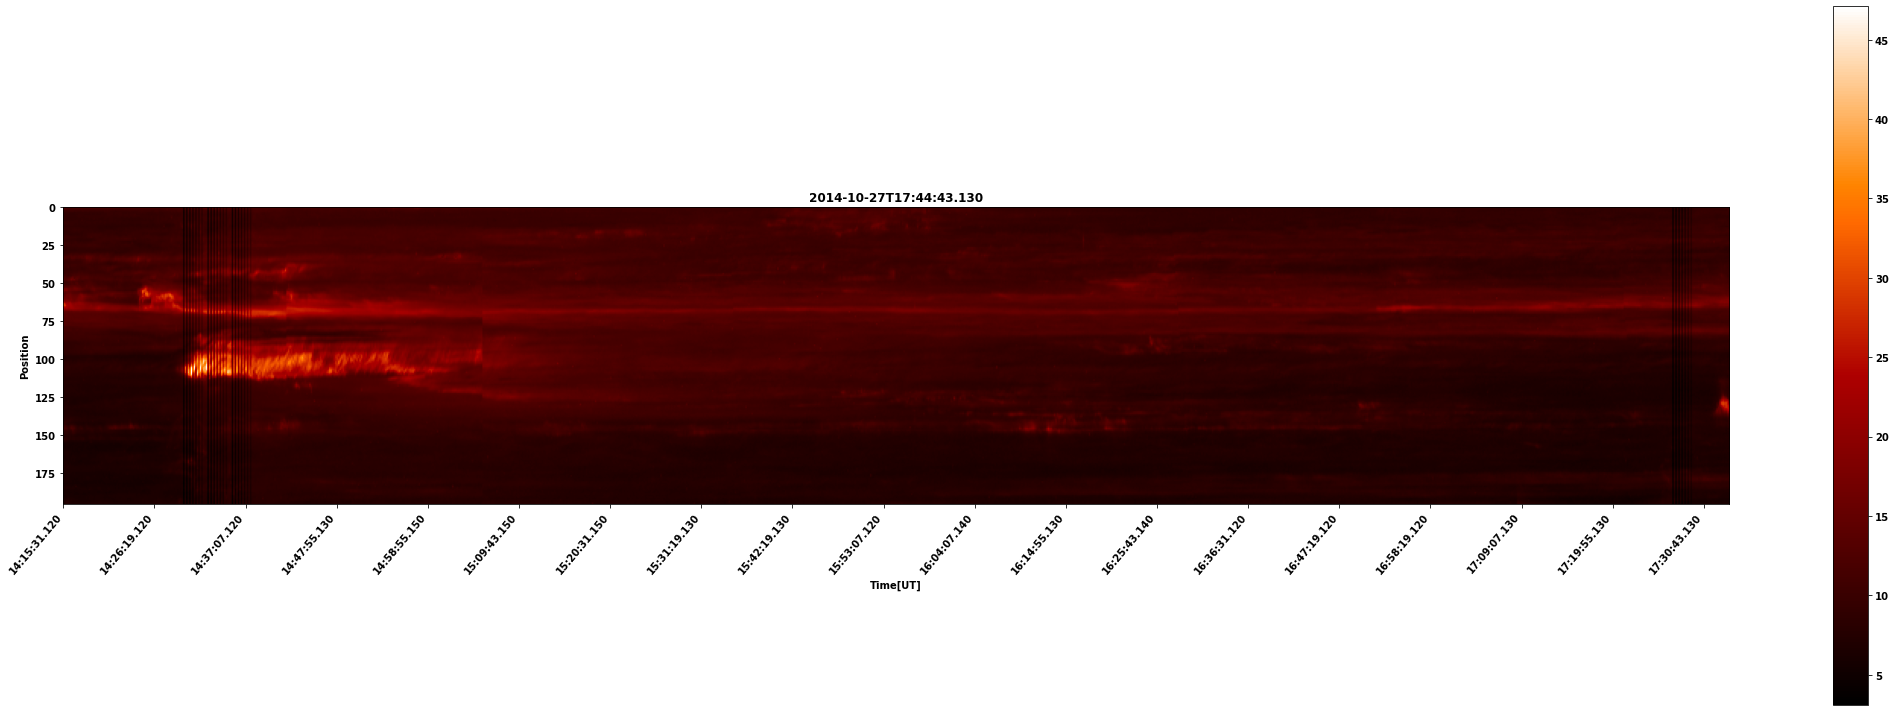

In [2]:
plt.rcParams.update({'figure.autolayout': True})
from matplotlib.ticker import MaxNLocator
df = pd.read_excel('IRIS_AIA.xlsx' , sheet_name='Tabelle3')

folder = '/Users/delbe/OneDrive - FHNW/aia_304/'
    
for label, row in df.iterrows():
    p1_x1 = row[1]
    p1_y1 = row[2]
    p2_x2 = row[3]
    p2_y2 = row[4]

    # time_axis = row[5].split("T")

    gradient = (p2_y2-p1_y1)/(p2_x2-p1_x1)
    origin = p1_y1 - gradient * p1_x1

    y = np.arange(min(p1_y1, p2_y2),max(p1_y1, p2_y2)+1)
    x = (y - origin) / gradient

    coords = (np.column_stack((x.round().astype(int),y.astype(int))))
    
    files = glob.glob(folder + row[0] + "/*")

    aia0_map = sunpy.map.Map(files[0])
    aiaN_map = sunpy.map.Map(files[-1])

    aia0_date = aia0_map.date
    aiaN_date = aiaN_map.date

    pt = aiapy.calibrate.util.get_pointing_table(aia0_date - 12*u.h, aiaN_date + 12*u.h)                           

    aia_updated_pointing_0 = aiapy.calibrate.update_pointing(aia0_map, pointing_table=pt)
    aia_0 = aiaprep(aia_updated_pointing_0)

    skycoords = aia0_map.pixel_to_world(coords[:,0] * u.pix, coords[:,1] * u.pix)


    final_image = []
    list_dates = []

    for i in range(0,len(files)-1):
    # for i in range(0,60):

        if i%10 == 0:
            print(i, end=',')

        try:         
            aia_i_map = sunpy.map.Map(files[i])

        except: 
            continue

        aia_updated_pointing_i = aiapy.calibrate.update_pointing(aia_i_map, pointing_table=pt)

        aia_i = aiaprep(aia_updated_pointing_i)

        skycoords_i = solar_rotate_coordinate(skycoords, time=(aia_i.date - aia_0.date).to(u.s))
        pxcoords_i = aia_i_map.world_to_pixel(skycoords_i) # aia_i => aia_map0

        spilltet_date = aia_i.date.isot.split("T")
        list_dates.append(spilltet_date[1]) 

        coords_x = pxcoords_i.x.value
        coords_y = pxcoords_i.y.value.round().astype('int')

        x_floor_coords = [coords_y, np.floor(coords_x).astype(int)] 
        x_ceil_coords = [coords_y, np.ceil(coords_x).astype(int)] 
        x_mod = coords_x % 1

        zi1 = np.flipud(aia_i.data**0.4)[tuple(x_floor_coords)]
        zi2 = np.flipud(aia_i.data**0.4)[tuple(x_ceil_coords)]

        zi = zi1 * (1 - x_mod) + zi2 * x_mod

        if len(final_image) == 0: 
            final_image = zi 
        else:
            final_image = np.vstack([final_image, zi])

    fig, ax = plt.subplots(figsize=[30,10])      

    plt.title(aia_i.date.isot)

    # # defining and sitting the number of ticks:
    nticks = 20 
    ax.xaxis.set_major_locator(MaxNLocator(nticks))
    ax.set_xticklabels(list_dates[::int(len(list_dates)/nticks)], rotation = 50, horizontalalignment="right")

    im = plt.imshow(final_image.transpose(),cmap = aia_i.cmap)
    plt.colorbar()

    plt.xlabel('Time[UT]')
    plt.ylabel('Position')
    
    np.save(f"../final_data/aia_times/{row[0]}_time" , list_dates)
    np.save(f"../final_data/aia_data/{row[0]}_data " , final_image)
    
    plt.show()